# Анализ комментариев интернет-магазина

Интернет-магазин запускает новый сервис: могут редактировать и дополнять описания товаров, как в вики-сообществах (клиенты предлагают свои правки и комментируют изменения других). Необходимо разработать инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
<br>Нужно обучить модель классифицировать комментарии на позитивные и негативные, на основании размеченного корпуса текста.
<p>Успешной будет считаться модель со значением метрики качества F1 не меньше 0.75.</p>
<br>
<br>
Значения столбцов датасета:

- `Text` — текст комментария
- `Toxic` — флаг токсичности комментария (1 - токсичный, 0 - не токсичный).

## 1. Подготовка данных

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Импорты для работы с текстом.
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.metrics import f1_score, confusion_matrix

In [2]:
# Если не установлены библиотеки.
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Roman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Roman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv('datasets/toxic_comments.csv')

In [4]:
df.info()
display(df.head())
print('\nЯвных дубликатов комментариев:', df['text'].duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0



Явных дубликатов комментариев: 0


Проверим пропуски и распределение токчных/не токсичных комментариев.

In [5]:
df['toxic'].value_counts() /  df['toxic'].count()

0    0.898321
1    0.101679
Name: toxic, dtype: float64

Посмотрим на распределение длины комментариев.

In [6]:
df_text_type = df.copy()
df_text_type['length'] = df['text'].apply(len)
df_text_type.groupby('toxic').agg({'length':['count','mean', 'median', 'min', 'max']})

length                             
        count        mean median min   max
toxic                                     
0      143346  404.347174    216   6  5000
1       16225  303.304037    128   8  5000

[Text(0.5, 1.0, 'Распределение длины комментариев'),
 Text(0.5, 0, 'Длина комментария, символов'),
 Text(0, 0.5, 'Частота')]

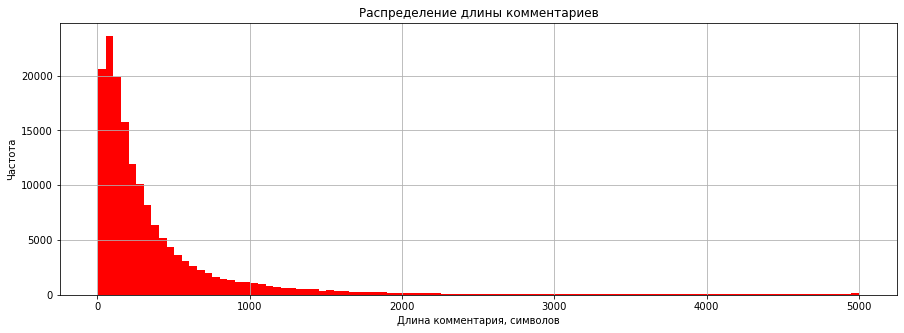

In [7]:
df_text_type['length'].hist(bins=100, figsize=(15,5), color='r')\
.set(title='Распределение длины комментариев', xlabel='Длина комментария, символов', ylabel='Частота')

[Text(0.5, 1.0, 'Распределение длины токсичных комментариев'),
 Text(0.5, 0, 'Длина комментария, символов'),
 Text(0, 0.5, 'Частота')]

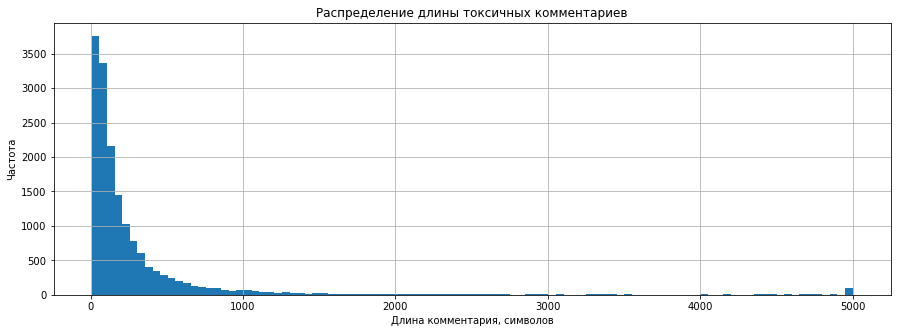

In [8]:
df[df['toxic'] == 1]['text'].apply(len).hist(bins=100, figsize=(15,5))\
.set(title='Распределение длины токсичных комментариев', xlabel='Длина комментария, символов', ylabel='Частота')

[Text(0.5, 1.0, 'Распределение длины нетоксичных комментариев'),
 Text(0.5, 0, 'Длина комментария, символов'),
 Text(0, 0.5, 'Частота')]

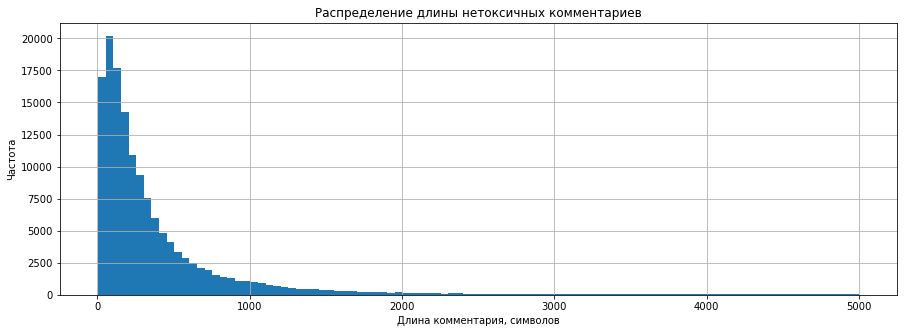

In [9]:
df[df['toxic'] == 0]['text'].apply(len).hist(bins=100, figsize=(15,5))\
.set(title='Распределение длины нетоксичных комментариев', xlabel='Длина комментария, символов', ylabel='Частота')

**Выводы**

- датасет содержит 159 571 комментариев 11% которых помечены как токсичные,
- пропуски и дубликаты в датасете отсуствуют,
- как общее распределение длины комментарием, так и распределение отдельно взятых токсчиных и нетоксичных комментариев - пуассоновские,
- Медианная длинна токсичного комментария на 68% меньше, чем нетоксичного (128 против 216, соответственно).

## 2. Обучение модей

### 2.1. Подготовка признаков

Подготовка текcта состоит из 2 этапов:
- удаление специальных символов и чисел,
- лемматизация.

In [10]:
wnl = WordNetLemmatizer()

In [11]:
target = df['toxic']
features = df['text'].apply(lambda x: ' '.join([wnl.lemmatize(re.sub(r'[^a-zA-Z]', ' ', i).lower()) for i in x.split()]))

features

0         explanation why the edits made under my userna...
1         d aww  he match this background colour i m see...
2         hey man  i m really not trying to edit war  it...
3           more i can t make any real suggestion on imp...
4         you  sir  are my hero  any chance you remember...
                                ...                        
159566          and for the second time of asking  when ...
159567    you should be ashamed of yourself that is a ho...
159568    spitzer umm  there no actual article for prost...
159569    and it look like it wa actually you who put on...
159570      and     i really don t think you understand ...
Name: text, Length: 159571, dtype: object

Выделим обучающую, валидационную и тестовую выборки.

In [12]:
# Выделяем из исходных данных тестовую выборку.
(features_train,
 features_test,
 target_train,
 target_test) = train_test_split(features, target, test_size=0.1, random_state=12345, stratify=target)


# Разделяем оставшиеся данные на обучающую и валидационную выборки.
(features_train,
 features_valid,
 target_train,
 target_valid) = train_test_split(features_train, target_train, test_size=0.1, random_state=12345, )


# Проверяем корерктность рассплитовки.
if features_train.shape[0] + features_valid.shape[0] + features_test.shape[0] == df.shape[0]:
    print('Датасет раздлен на выборки корректно.\n')
else:
    print('Датасет раздлен на выборки некорректно.\n')

print('Исходный датасет включает:', df.shape[0],
      '\nОбучающая выборка включает:', features_train.shape[0], f'или {features_train.shape[0]/df.shape[0]:.0%} датасета'
      '\nВалидационная выборка включает:', features_valid.shape[0], f'или {features_valid.shape[0]/df.shape[0]:.0%} датасета'
      '\nТестовая выборка включает:', features_test.shape[0], f'или {features_test.shape[0]/df.shape[0]:.0%} датасета')

Датасет раздлен на выборки корректно.

Исходный датасет включает: 159571 
Обучающая выборка включает: 129251 или 81% датасета
Валидационная выборка включает: 14362 или 9% датасета
Тестовая выборка включает: 15958 или 10% датасета


Векторизируем текст.

In [13]:
# Инициализация векторайзера и стоп-слов.
stopwords = set(nltk_stopwords.words('english'))
tfv = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,2))

# Обучение векторайзера на обучающей выборке.
features_vector_train = tfv.fit_transform(features_train)

# Применение векторайзера к валидационной и тестовой выборкам.
features_vector_valid = tfv.transform(features_valid)
features_vector_test = tfv.transform(features_test)

### 2.2. Обучение моделей

In [14]:
# Словарь для хранения лучших параметров обученных моделей.
model_best_params = {}

# Словарь для хранения скорости обучения в секундах.
model_speed_train = {}

# Словарь для хранения F1 на тесте.
model_score_train = {}

# Словарь для хранения F1 на валидации.
model_score_valid = {}



# Функция для обучения и валидации моделей.
def train_valid(model, params):
    # Переменная для хранения имени модели.
    name =[x for x in globals() if globals()[x] is model][0]
    train_start = time.time()
    
    GSCV = GridSearchCV(model,
                        params,
                        scoring='f1_macro',
                        cv=2)
    
    GSCV.fit(features_vector_train, target_train)
    
    train_time = time.time() - train_start
    
    
    F1_train = GSCV.best_score_
    valid_predictions = GSCV.predict(features_vector_valid)
    F1_valid = f1_score(valid_predictions, target_valid)
    
    print('Время обучения модели, сек.:', np.round_(train_time))
    print('F1 лучшей модели на обучающей выборке:', F1_train)
    print('F1 лучшей модели на валидационной выборке:', F1_valid)
    
    model_best_params[name] = GSCV.best_estimator_
    model_speed_train[name] = train_time
    model_score_train[name] = F1_train
    model_score_valid[name] = F1_valid

Обучим модель <b><u>решающего дерева</u></b>.

In [15]:
# Список параметров модели:
# list(LR_model.get_params().keys())

In [16]:
DTC_model = DecisionTreeClassifier(random_state=12345)

DTC_params = {'class_weight':['balanced'],
             'max_depth':[10]}  

In [17]:
train_valid(DTC_model, DTC_params)

Время обучения модели, сек.: 360.0
F1 лучшей модели на обучающей выборке: 0.6159900104027549
F1 лучшей модели на валидационной выборке: 0.5678346810422283


Обучим модель <b><u>случайного леса</u></b>.

In [18]:
RFC_model = RandomForestClassifier(random_state=12345)

RFC_params = {'class_weight':['balanced'],
             'n_estimators':[100],
             'max_depth':[10]}  

In [19]:
train_valid(RFC_model, RFC_params)

Время обучения модели, сек.: 163.0
F1 лучшей модели на обучающей выборке: 0.5211123551659969
F1 лучшей модели на валидационной выборке: 0.3050807497347637


Обучим модель <b><u>логистической регрессии</u></b>.

In [20]:
LR_model = LogisticRegression(random_state=12345)

LR_params = {'class_weight':['balanced'],
             'C':[3],
             'max_iter':[100]}  

In [21]:
train_valid(LR_model, LR_params)

Время обучения модели, сек.: 117.0
F1 лучшей модели на обучающей выборке: 0.867404537609827
F1 лучшей модели на валидационной выборке: 0.7761006289308177


C:\Users\Roman\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Обучим модель <b><u>стохастического градиентного спуска</u></b>.

In [22]:
SGD_model = SGDClassifier(random_state=12345)

SGD_params = {
        'class_weight':['balanced'],
        'max_iter':[1000],
        'shuffle':[True],
        'penalty':['l1'],
        'n_iter_no_change':[30]}

In [23]:
train_valid(SGD_model, SGD_params)

Время обучения модели, сек.: 18.0
F1 лучшей модели на обучающей выборке: 0.8490143669276
F1 лучшей модели на валидационной выборке: 0.725360576923077


### 2.3. Тестирование моделей

In [24]:
# Словарь для хранения F1 на тестовой выборке.
model_score_test = {}

# Функция для тестирования и вывода резульаттов.
def test_model(model_name, model, features_test, target_test):
    

    predictions = model.predict(features_test)
    F1_test = f1_score(predictions, target_test)
    
    model_score_test[model_name] = F1_test
    
    print('\033[1m' + f'Значение F1 модели {model_name} на тестовой выборке:' + '\033[0m', F1_test)
    
    
    # Визуализация.
    plt.figure(figsize=(4,3))
    sns.heatmap(confusion_matrix(target_test, predictions, normalize='true'), annot=True,fmt='.0%')
    plt.title(f'Матрица ошибок модели {model_name}', y=1.05, size=10)

Значение F1 модели DecisionTreeClassifier(DTC) на тестовой выборке: 0.5505571605447792
Значение F1 модели RandomForestClassifier(RFC) на тестовой выборке: 0.2999139414802065
Значение F1 модели LogisticRegression(LR) на тестовой выборке: 0.776608187134503
Значение F1 модели SGDClassifier(SGD) на тестовой выборке: 0.7169392847241475


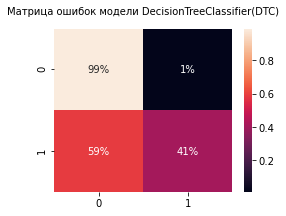

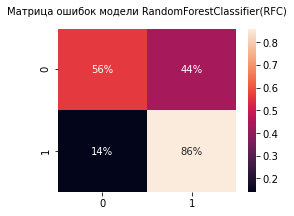

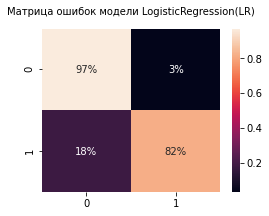

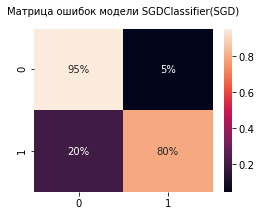

In [25]:
test_model('DecisionTreeClassifier(DTC)', model_best_params['DTC_model'], features_vector_test, target_test)
test_model('RandomForestClassifier(RFC)', model_best_params['RFC_model'], features_vector_test, target_test)
test_model('LogisticRegression(LR)', model_best_params['LR_model'], features_vector_test, target_test)
test_model('SGDClassifier(SGD)', model_best_params['SGD_model'], features_vector_test, target_test)

Сравним резульаты моделей.

In [26]:
summary = pd.DataFrame(columns=['LR_model', 'RFC_model', 'DTC_model', 'SGD_model'],
                           index=['Train time, sec.', 'F1 train', 'F1 valid', 'F1 test'],
                           data=([model_speed_train['LR_model'], model_speed_train['RFC_model'], model_speed_train['DTC_model'], model_speed_train['SGD_model']],
                                 [model_score_train['LR_model'], model_score_train['RFC_model'], model_score_train['DTC_model'], model_score_train['SGD_model']],
                                 [model_score_valid['LR_model'], model_score_valid['RFC_model'], model_score_valid['DTC_model'], model_score_valid['SGD_model']],
                                 [model_score_test['DecisionTreeClassifier(DTC)'], model_score_test['RandomForestClassifier(RFC)'], model_score_test['LogisticRegression(LR)'], model_score_test['SGDClassifier(SGD)']]
                                ))

summary

,LR_model,RFC_model,DTC_model,SGD_model
"Train time, sec.",116.857191,162.882752,359.855991,18.256557
F1 train,0.867405,0.521112,0.615990,0.849014
F1 valid,0.776101,0.305081,0.567835,0.725361
F1 test,0.550557,0.299914,0.776608,0.716939


**Выводы**

- датасет был разделен на обучающую, валидационную и тестовую выборки в пропорции 81%/9%/10%. Проведена лемматизация целевого признака, а также удаление лишних символов и стоп-слов с последующей векторизацией,
- проведено обучение 4 моделей классификации: решающего дерева, случайного леса, логистической регрессии и стохастического градиентного спуска, 
- построены матрицы ошибок на тестовой выборке,
- результаты работы моделей (время обучения, F1 на обучающей, валидационной и тестовой выборках) представлны в сводной таблице.

## 3. Итоги исследования

Среди 4 моделей наилучший результат на тестовой выборке показала логистическая регрессия (F1 = 0.78), что также отражено на матрице ошибок: True Positive 82%, True Negative 97%.